In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf 
from tensorflow import keras 
from keras import layers
from keras.models import Sequential 
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import DenseNet201
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt 
import seaborn as sns
import glob 
import cv2
from tqdm import tqdm
import pathlib

In [2]:
dataset = pathlib.Path("../lung_colon_image_set/")
images = list(dataset.glob('*/*/*.jpeg'))

lbt = dataset.glob('lung_image_sets/lung_n/*')
laca = dataset.glob('lung_image_sets/lung_aca/*')
lscc = dataset.glob('lung_image_sets/lung_scc/*')
cacc = dataset.glob('colon_image_sets/colon_aca/*')
cbt = dataset.glob('colon_image_sets/colon_n/*')

lung_benign_tissue = list(lbt)
lung_adenocarcinoma = list(laca)
lung_squamous_cell_carcinoma = list(lscc)
colon_adenocarcinoma = list(cacc)
colon_benign_tissue = list(cbt)

In [3]:
label_dict = {
    'lung_benign_tissue' : 0,
    'lung_adenocarcinoma' : 1,
    'lung_squamous_cell_carcinoma' : 2,
    'colon_adenocarcinoma' : 3,
    'colon_benign_tissue' : 4
}

image_dict = {
    'lung_benign_tissue' : lung_benign_tissue,
    'lung_adenocarcinoma' : lung_adenocarcinoma,
    'lung_squamous_cell_carcinoma' : lung_squamous_cell_carcinoma,
    'colon_adenocarcinoma' : colon_adenocarcinoma,
    'colon_benign_tissue' :colon_benign_tissue
}

In [4]:
x,y = [],[]

for name,images in tqdm(image_dict.items(), desc='Processing Images'):
    for i in tqdm(images, desc=f'Processing {name} Images', leave=False):
        img = cv2.imread(str(i))
        re_img = cv2.resize(img,(200,200))
        re_img=np.round((re_img.astype(np.float16)/255.0),4)
        x.append(re_img)
        y.append(label_dict[name])

x = np.array(x)
y = np.array(y)

Processing Images: 100%|██████████| 5/5 [04:12<00:00, 50.43s/it]


In [5]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.7,random_state=10)
x_test,x_val,y_test,y_val = train_test_split(x_test,y_test,test_size=0.5,random_state=100)

In [6]:
print("X train : ",x_train.shape)
print("X test : ",x_test.shape)

X train :  (14000, 200, 200, 3)
X test :  (3000, 200, 200, 3)


In [7]:
model = Sequential()
inc_res_model = DenseNet201(weights='imagenet',include_top=False,input_shape=(200,200,3))
model.add(inc_res_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(5,activation='softmax'))

for layer in inc_res_model.layers:
    layer.trainable = False

y_train_cat = to_categorical(y_train, num_classes=5)
y_test_cat = to_categorical(y_test,num_classes=5)
y_val_cat = to_categorical(y_val,num_classes=5)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 6, 6, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5)                 9605      
                                                                 
Total params: 18331589 (69.93 MB)
Trainable params: 9605 (37.52 KB)
Non-trainable params: 18321984 (69.89 MB)
_________________________________________________________________


In [9]:
history = model.fit(x_train,y_train_cat,validation_data=(x_val,y_val_cat),epochs=10,batch_size=32)
hist = pd.DataFrame(history.history)
print(hist)
hist.to_csv('densenet.csv',index=False)

Epoch 1/10
438/438 [==============================] - 1614s 4s/step - loss: 0.2218 - accuracy: 0.9354 - val_loss: 0.1059 - val_accuracy: 0.9680
Epoch 2/10
438/438 [==============================] - 1473s 3s/step - loss: 0.0830 - accuracy: 0.9757 - val_loss: 0.0794 - val_accuracy: 0.9723
Epoch 3/10
438/438 [==============================] - 1463s 3s/step - loss: 0.0610 - accuracy: 0.9819 - val_loss: 0.0581 - val_accuracy: 0.9823
Epoch 4/10
438/438 [==============================] - 1465s 3s/step - loss: 0.0482 - accuracy: 0.9854 - val_loss: 0.0491 - val_accuracy: 0.9853
Epoch 5/10
438/438 [==============================] - 1470s 3s/step - loss: 0.0408 - accuracy: 0.9875 - val_loss: 0.0445 - val_accuracy: 0.9853
Epoch 6/10
438/438 [==============================] - 1460s 3s/step - loss: 0.0354 - accuracy: 0.9895 - val_loss: 0.0434 - val_accuracy: 0.9853
Epoch 7/10
438/438 [==============================] - 1462s 3s/step - loss: 0.0323 - accuracy: 0.9904 - val_loss: 0.0390 - val_accuracy:

In [10]:
model.evaluate(x_test,y_test_cat)

94/94 [==============================] - 248s 3s/step - loss: 0.0361 - accuracy: 0.9883


[0.0361163392663002, 0.9883333444595337]

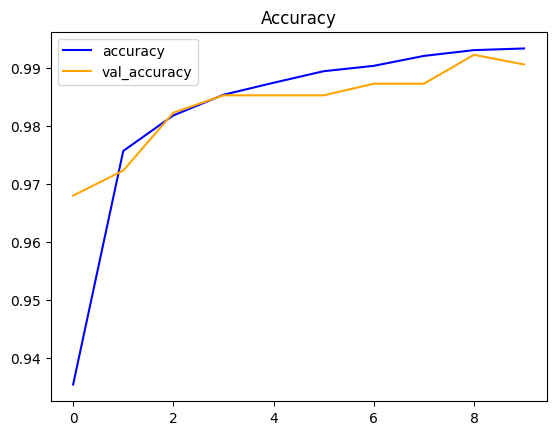

<Figure size 640x480 with 0 Axes>

In [11]:
plt.plot(history.history['accuracy'],color='blue',label='accuracy')
plt.plot(history.history['val_accuracy'],color='orange',label='val_accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()
plt.savefig('accuracy-densenet.png')

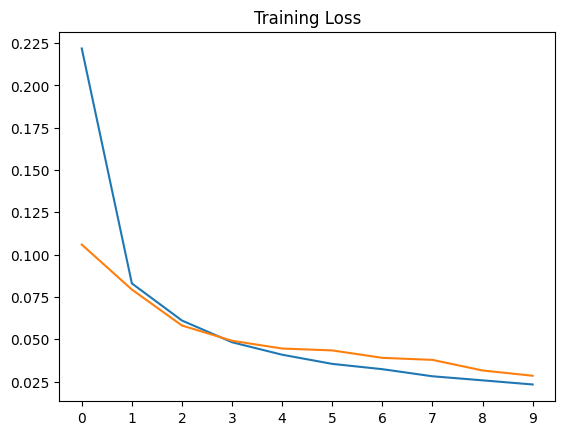

<Figure size 640x480 with 0 Axes>

In [12]:
x=list(range(0,10))
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.xticks(x)
plt.title("Training Loss")
plt.show()
plt.savefig("loss-densenet.png")

In [ ]:
model.save('densenet.h5')